In [222]:
import torch
import numpy as np
import matplotlib.pylab as plt

torch.set_default_tensor_type(torch.FloatTensor)

In [318]:
class QContour():
    def __init__(self, data_points):
        # data_points : nx2 numpy array
        self.data = data_points
        centerlize = self.data - self.data.mean(axis=0)
        self.var, self.pc = np.linalg.eigh(np.dot(centerlize.T, centerlize))
        self.pc_std = np.sqrt(self.var/len(self.data))
        self.normal_data = torch.tensor(np.dot(centerlize, self.pc)/self.pc_std, dtype=torch.float32)
        
        self.region_bound = torch.nn.Linear(2, 4, bias=True)
        self.region_bound.weight.data = torch.tensor([[0.3, 0.], [0., 0.3], [-0.3, 0.], [0., -0.3]])
        self.region_bound.bias.data = torch.ones(4)
        
        self.totally_score = torch.nn.Linear(4, 1, bias=True)
        self.totally_score.weight.data = torch.ones(1,4)
        self.totally_score.bias.data = torch.tensor([-2.])
    
    def forward(self, x):
        x = torch.sigmoid(self.region_bound(x))
        x = torch.sigmoid(self.totally_score(x))
        return x
    
    def fit(self, epoch, lr=1e-2, betas=(0.9, 0.999), weight_decay=0):
        self.optimizer = torch.optim.Adam([self.region_bound.weight, self.region_bound.bias,
                                           self.totally_score.bias],
                                          lr=lr, betas=betas, weight_decay=weight_decay)
        self.criterion = torch.nn.MSELoss()
        for e in range(epoch):
            self.optimizer.zero_grad()
            datums = len(self.normal_data)
            extend_input = torch.cat((self.normal_data, 8*torch.rand((int(0.2*datums), 2))-4), 0)
            extend_label = torch.ones(int(1.2*datums), 1)
            extend_label[datums:] *= 0
            loss = self.criterion(self.forward(extend_input), extend_label)
            loss.backward()
            self.optimizer.step()
    
    def get_vertice(self):
        output = torch.zeros(4,2)
        for i in range(-4, 0):
            output[i] = torch.gesv(self.region_bound.bias.data[[i,i+1]], -self.region_bound.weight.data[[i,i+1]])[0][:,0]
        
        output = output.numpy()
        output = np.dot(output*self.pc_std, self.pc.T) + self.data.mean(axis=0)
        return output

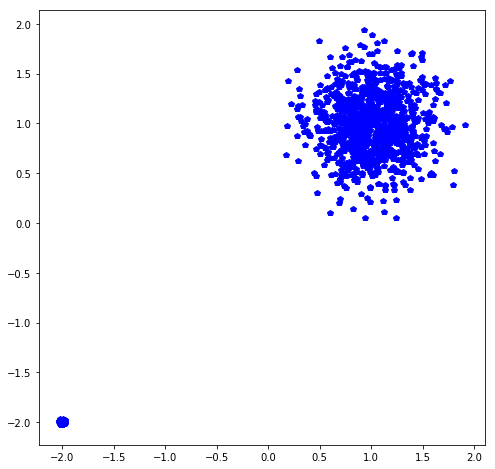

In [319]:
sample = np.concatenate([np.random.normal(1,0.3, (1000,2)), np.random.normal(-2,0.01, (1000,2))], axis=0)

plt.figure(figsize=(8,8))
plt.plot(input_[:,0], input_[:,1], "bp")
plt.show()

In [320]:
foo.criterion(foo.forward(torch.rand(4,2)), torch.ones(4,1))

tensor(0.0582, grad_fn=<MseLossBackward>)

In [325]:
foo = QContour(sample)
foo.fit(1000, lr=0.1, betas=(0., 0.999), weight_decay=0.0)

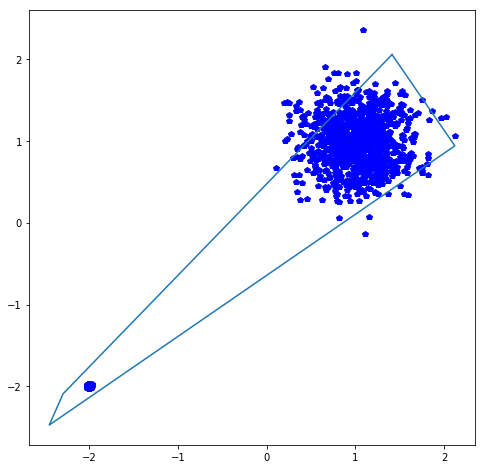

In [326]:
fooo = foo.get_vertice()
plt.figure(figsize=(8,8))
plt.plot(sample[:,0], sample[:,1], "bp")
plt.plot(fooo[[0,1,2,3,0],0], fooo[[0,1,2,3,0],1])
plt.show()